<h1> BART for inequalities </h1>

Quick comparison of Random Forest and BART in fitting income distribution data to predict life expectancy

In [39]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Preprocessing </h2>

We want to use income distribution to predict life expectancy. So we need the design matrix <b> X </b> to contain all of the income information, and the targets <b> y </b> to represent the life expectancies of each country

Life expectancy for all countries from the World Bank

In [2]:
life_exp_df = pd.read_csv("wb_life_expectancy.csv", skiprows = 4)
life_exp_df = life_exp_df[["Country Name", "2017"]]
life_exp_df.rename(columns = {"2017":"Life Expectancy 2017"}, inplace=True)
life_exp_df = life_exp_df.dropna()
life_exp_df

,Country Name,Life Expectancy 2017
0,Aruba,76.010000
1,Afghanistan,64.130000
2,Angola,60.379000
3,Albania,78.333000
5,Arab World,71.622526
...,...,...
259,Kosovo,71.946341
260,"Yemen, Rep.",66.086000
261,South Africa,63.538000
262,Zambia,63.043000


Income distribution for all countries and world regions from WID.world. The distribution is split into bottom 50 percent, 50-90 percent (middle class), top 10 percent and the top 1 percent share

In [3]:
income_df = pd.read_csv("wid_income_dist.csv", skiprows = 1, sep = ";", header = None)
income_df = income_df[[0, 2, 4]]
income_df.columns = ["Region Name", "percentile", "Income Share"]
income_df = income_df.dropna() # Only keep regions with all 4 parts of the income distribution
income_df = income_df.pivot(index='Region Name', columns='percentile')['Income Share'] # reshape, col per share
income_df

percentile,p0p50,p50p90,p90p100,p99p100
Region Name,,,,
Africa,0.088212,0.368794,0.542994,0.190221
Albania,0.209400,0.470900,0.319700,0.082100
Algeria,0.207066,0.420077,0.372856,0.097033
Angola,0.130631,0.380834,0.488535,0.151751
Austria,0.234300,0.449100,0.316600,0.092700
...,...,...,...,...
United Kingdom,0.206100,0.439300,0.354600,0.126100
Western Africa,0.116490,0.375802,0.507708,0.164721
Zambia,0.073127,0.311930,0.614943,0.230787


Merge the life expectancy and income dataframes on country

In [4]:
le_income_df = life_exp_df.merge(income_df, left_on = "Country Name", right_on = "Region Name")
le_income_df

,Country Name,Life Expectancy 2017,p0p50,p50p90,p90p100,p99p100
0,Angola,60.379000,0.130631,0.380834,0.488535,0.151751
1,Albania,78.333000,0.209400,0.470900,0.319700,0.082100
2,Austria,81.641463,0.234300,0.449100,0.316600,0.092700
3,Burundi,60.898000,0.151344,0.371082,0.477574,0.145485
4,Belgium,81.439024,0.205900,0.480100,0.313900,0.077700
...,...,...,...,...,...,...
79,Tanzania,64.479000,0.153972,0.365047,0.480980,0.161714
80,Uganda,62.516000,0.131229,0.353945,0.514826,0.168541
81,South Africa,63.538000,0.062700,0.286500,0.650800,0.192100
82,Zambia,63.043000,0.073127,0.311930,0.614943,0.230787


In [5]:
X = le_income_df[["p0p50", "p50p90", "p90p100", "p99p100"]]
y = le_income_df[["Life Expectancy 2017"]]

<h2> Random Forest implementation </h2>

First, try fitting a Random Forest algorithm with 10 trees, for comparison

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
# use pipeline in case we add preprocessing in the future
rf_pipeline = Pipeline(steps=[("model", RandomForestRegressor(n_estimators = 10, random_state = 0))
                             ])

In [16]:
from sklearn.model_selection import cross_val_score
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(rf_pipeline, X, y,
                              cv = 5,
                              scoring = "neg_mean_absolute_error")

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [3.59117346 2.56071964 5.68925601 3.39699125 4.89878293]
Average MAE score (across experiments):
4.027384656285378


Now use a quick grid search to find the best tree size

In [8]:
from sklearn.model_selection import GridSearchCV
parameters = {"model__n_estimators": np.arange(5, 85 + 1, 20)}
grid_search = GridSearchCV(rf_pipeline, parameters)
grid_search.fit(X, y)
grid_search.best_params_

{'model__n_estimators': 45}

Reassess the model performance with optimised tree size

In [9]:
rf_pipeline = Pipeline(steps=[("model", RandomForestRegressor(n_estimators = grid_search.best_params_["model__n_estimators"], random_state = 0))
                             ])
                             
scores = -1 * cross_val_score(rf_pipeline, X, y,
                              cv = 5,
                              scoring = "neg_mean_absolute_error")

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [3.76447217 2.82785205 5.27005592 3.46856951 4.47042022]
Average MAE score (across experiments):
3.9602739738883015


<h2> bartpy implementation </h2>

In [11]:
X = le_income_df[["p0p50", "p50p90", "p90p100", "p90p100"]]
y = le_income_df["Life Expectancy 2017"].values # needs to be an array

Fit BART for 10 trees

In [13]:
from bartpy.sklearnmodel import SklearnModel
bart_pipeline = Pipeline(steps=[("model", SklearnModel(n_burn = 100, n_chains = 1, n_jobs = 1, n_samples = 1000, n_trees = 10))
                             ])

In [18]:
scores = -1 * cross_val_score(bart_pipeline, X, y,
                              cv = 5,
                              scoring = "neg_mean_absolute_error")
                              
print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

100%|██████████| 1000/1000 [00:24<00:00, 40.22it/s]
MAE scores:
 [3.55368402 3.6734292  4.82290294 3.57310689 5.32443811]
Average MAE score (across experiments):
4.189512227458425


Random Forest performs better

Optimise the number of trees and recalculate the error

In [14]:
parameters = {"model__n_trees": np.arange(5, 85 + 1, 20)}
grid_search = GridSearchCV(bart_pipeline, parameters)
grid_search.fit(X, y)
grid_search.best_params_

Starting burn
100%|██████████| 1000/1000 [00:30<00:00, 32.31it/s]


{'model__n_trees': 45}

In [17]:
bart_pipeline = Pipeline(steps=[("model", SklearnModel(n_burn = 100, n_chains = 1, n_jobs = 1, n_samples = 1000, n_trees = grid_search.best_params_["model__n_trees"]))
                               ])
scores = -1 * cross_val_score(bart_pipeline, X, y,
                              cv = 5,
                              scoring = "neg_mean_absolute_error")
                              
print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

100%|██████████| 1000/1000 [00:21<00:00, 46.69it/s]
MAE scores:
 [3.78358866 2.38956266 4.87097877 3.96268451 4.64446884]
Average MAE score (across experiments):
3.9302566887194095


bartpy now performs slightly better, but it took ages doing so

<h2> Predictions </h2>

The main advantage of BART is that we can get Bayesian errors from the posterior samples. So we will now compare the predictions of both algorithms (with BART's errors) to the true life expectancy of each country

In [19]:
rf_pipeline.fit(X, y)
y_pred_rf = rf_pipeline.predict(X)
le_income_df["Random Forest LE"] = y_pred_rf

In [20]:
# Same pipeline but storing in sample predictions to allow for error calculation
bart_pipeline = Pipeline(steps=[("model", SklearnModel(n_burn = 100, n_chains = 1, n_jobs = 1, n_samples = 1000, n_trees = grid_search.best_params_["model__n_trees"], store_in_sample_predictions = True))
                               ])
bart_pipeline.fit(X, y)
y_pred_bart = bart_pipeline.predict(X)
le_income_df["BART LE"] = y_pred_bart

100%|██████████| 1000/1000 [00:29<00:00, 34.08it/s]


In [21]:
# Calculate errors
# The method below assumes that you are predicting in sample (i.e the X used for fit is the same as used for predict)

# Thin is 1 in 10 so for 1000 samples, we can get 100 samples to calculate the error
samples = bart_pipeline["model"]._prediction_samples
# should have self.prediction_samples() method but error in package where bartpy return self.prediction_samples instead of self._prediction_samples
unnormalised_samples = bart_pipeline["model"].data.y.unnormalize_y(samples)
y_pred_bart_ci95 = np.std(unnormalised_samples, axis = 0)*1.96 # 95% confidence intervals
le_income_df["BART LE ci95"] = y_pred_bart_ci95

In [22]:
le_income_df

,Country Name,Life Expectancy 2017,p0p50,p50p90,p90p100,p99p100,Random Forest LE,BART LE,BART LE ci95
0,Angola,60.379000,0.130631,0.380834,0.488535,0.151751,59.712300,61.307374,0.553255
1,Albania,78.333000,0.209400,0.470900,0.319700,0.082100,79.315180,79.719525,0.461312
2,Austria,81.641463,0.234300,0.449100,0.316600,0.092700,81.906098,81.112622,0.467951
3,Burundi,60.898000,0.151344,0.371082,0.477574,0.145485,63.333533,65.423407,0.541370
4,Belgium,81.439024,0.205900,0.480100,0.313900,0.077700,81.980488,80.201951,0.581860
...,...,...,...,...,...,...,...,...,...
79,Tanzania,64.479000,0.153972,0.365047,0.480980,0.161714,67.038600,65.423407,0.541370
80,Uganda,62.516000,0.131229,0.353945,0.514826,0.168541,64.292100,64.236910,0.611715
81,South Africa,63.538000,0.062700,0.286500,0.650800,0.192100,61.125500,60.351227,0.883246
82,Zambia,63.043000,0.073127,0.311930,0.614943,0.230787,62.499400,61.450735,0.482704


Plot true vs Random Forest vs BART with errors

In [33]:
# Reformat for plotting
le_df = le_income_df[["Country Name", "Life Expectancy 2017", "Random Forest LE", "BART LE"]]
le_df.rename(columns = {"Life Expectancy 2017":"World Bank", "Random Forest LE":"Random Forest", "BART LE":"BART"}, inplace=True)
le_df = pd.melt(le_df, id_vars=["Country Name"], value_vars=["World Bank", "Random Forest", "BART"], var_name = "Algorithm", value_name = "Life Expectancy")

error_df = le_income_df[["Country Name", "BART LE ci95"]]
error_df.rename(columns = {"BART LE ci95":"BART"}, inplace=True)
error_df["World Bank"], error_df["Random Forest"] = 0.0, 0.0
error_df = pd.melt(error_df, id_vars=["Country Name"], value_vars=["World Bank", "Random Forest", "BART"], var_name = "Algorithm", value_name = "ci95")
le_error_df = pd.merge(le_df, error_df)
le_error_df

,Country Name,Algorithm,Life Expectancy,ci95
0,Angola,World Bank,60.379000,0.000000
1,Albania,World Bank,78.333000,0.000000
2,Austria,World Bank,81.641463,0.000000
3,Burundi,World Bank,60.898000,0.000000
4,Belgium,World Bank,81.439024,0.000000
...,...,...,...,...
247,Tanzania,BART,65.423407,0.541370
248,Uganda,BART,64.236910,0.611715
249,South Africa,BART,60.351227,0.883246
250,Zambia,BART,61.450735,0.482704


<ErrorbarContainer object of 3 artists>

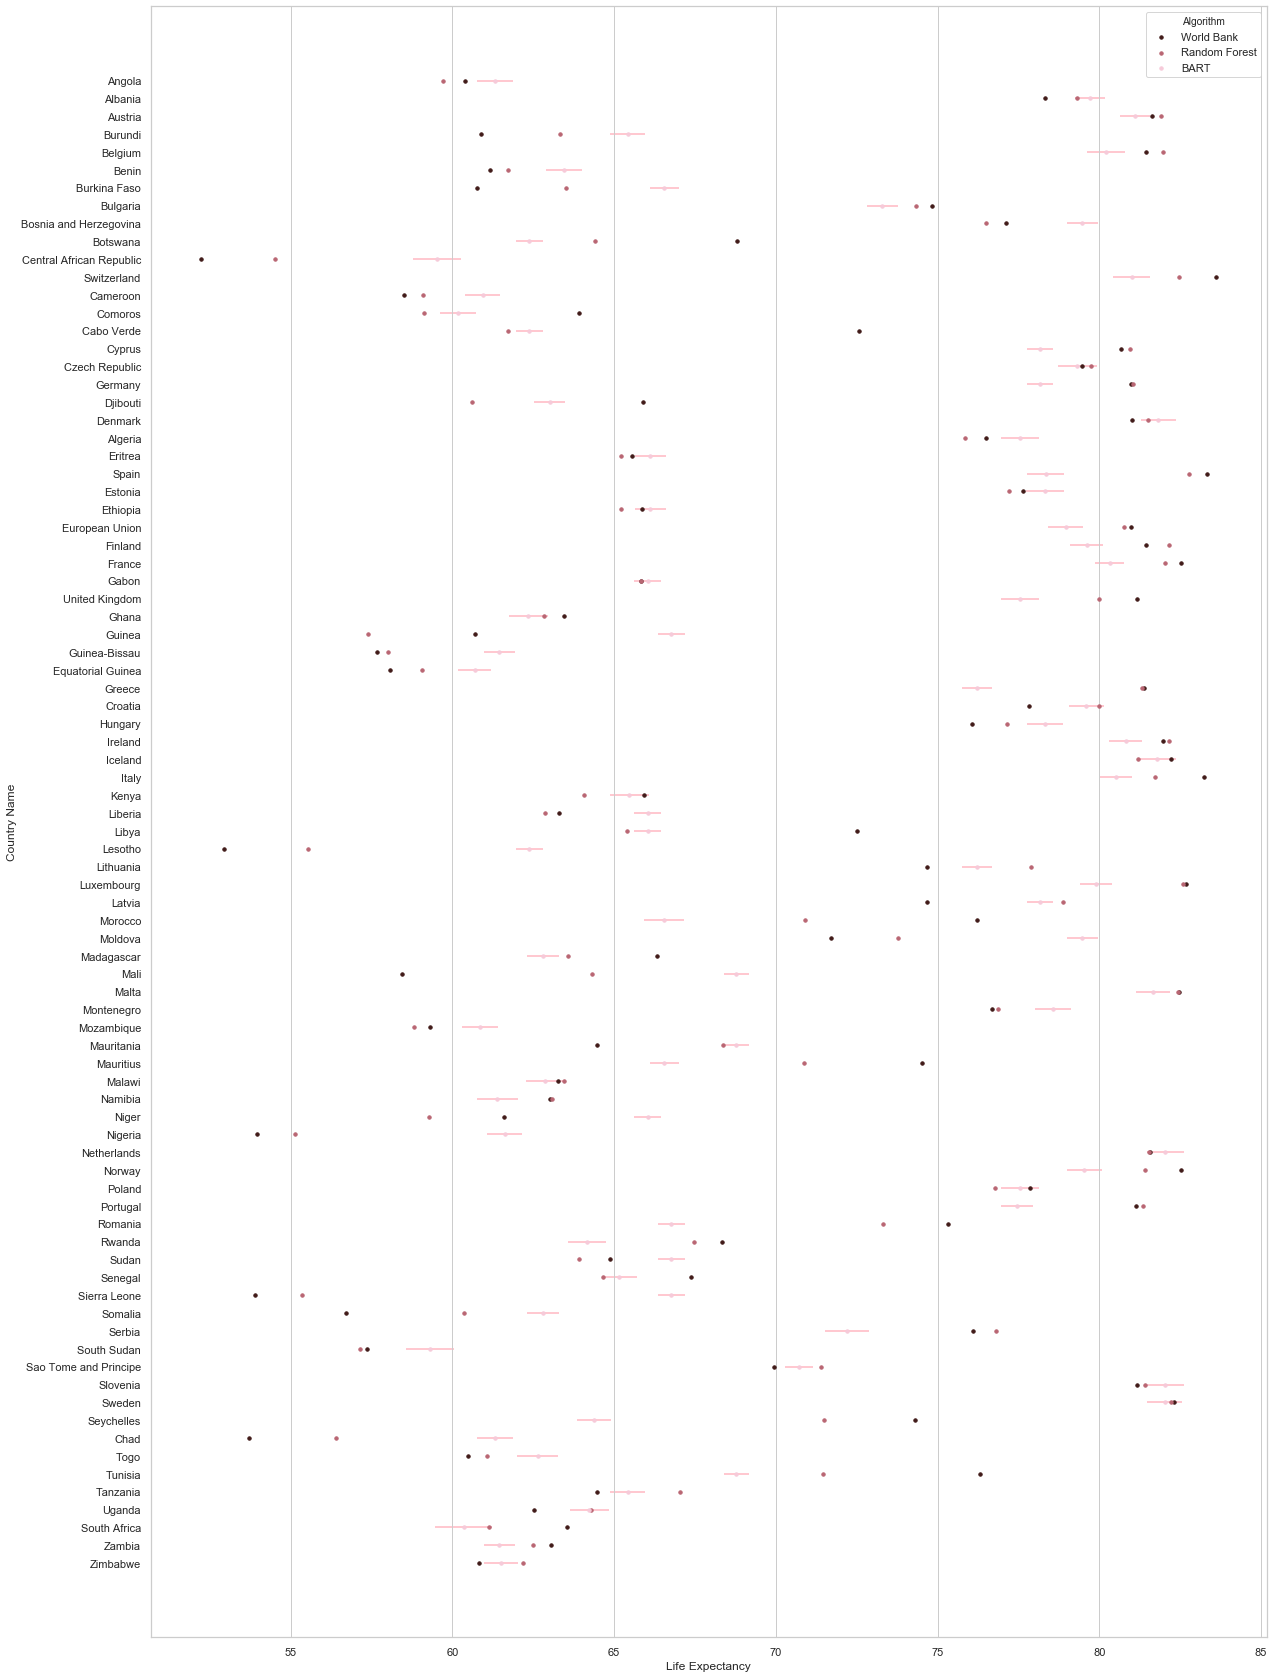

In [59]:
# Plot with TRUE vs RF vs bartpy
plt.figure(figsize = (20,30))
sns.set(style = "whitegrid")
ax = sns.pointplot(y = "Country Name", x = "Life Expectancy", hue = "Algorithm", data = le_error_df, join = False, xerr="ci95", errwidth = 10, scale = 0.5, palette = "ch:s=1, r=-.1, h=1_r")
ax.errorbar(y = le_error_df["Country Name"], x = le_error_df["Life Expectancy"], xerr = le_error_df["ci95"], fmt=' ', zorder = -1, color = "lightpink")